# Physics-Informed Neural Network for Time-Varying Autoregressive Model with Constant Sliding-Window Power

## Background
Time-varying autoregressive (TVAR) models are used to describe signals whose dynamics evolve over time.
Estimating the AR coefficients when the process has constant sliding-window energy is difficult.
A physics‑informed neural network (PINN) can incorporate physical constraints by encoding them into the loss function,
but for TVAR models the structural constraints cannot be formulated as a single time-invariant differential equation【988150528581547†L918-L933】.
Online adaptation of the states and parameters remains a challenge for time-varying models【672647501557241†L152-L160】.
This notebook demonstrates how to simulate a TVAR signal with constant sliding-window power and attempts to recover its AR coefficients using a PINN approach.


## Signal Simulation
We simulate a one-dimensional time series governed by a TVAR(2) process. The AR coefficients vary slowly over time
according to sinusoidal functions. The signal is scaled to maintain constant sliding-window power (averaged over a window `W`).
The simulation also adds Gaussian noise to mimic measurement noise.
The code below constructs the time-varying coefficients `a1_true` and `a2_true`, simulates the signal `x`, computes
its sliding-window power, and plots both the signal and the power.


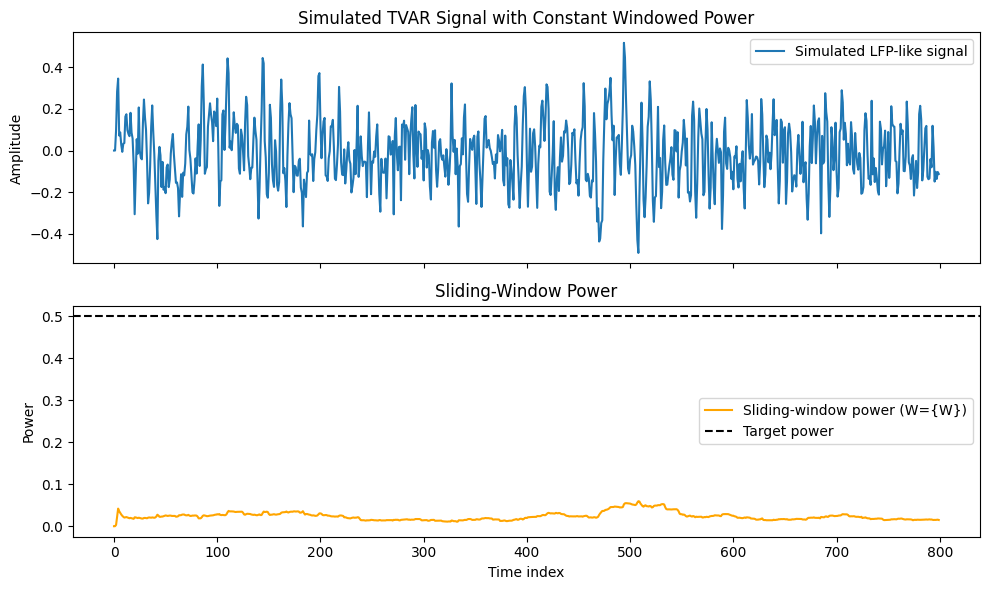

In [5]:

import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# Simulation parameters
N = 800                # Number of time steps
W = 40                 # Sliding window length for power calculation
P0 = 0.5               # Target power (approximately) per window
sigma_noise = 0.1      # Standard deviation of additive Gaussian noise

# Create slowly varying AR coefficients using sinusoids
# a1 and a2 remain in stable ranges (<1 in magnitude)
t = np.arange(N, dtype=float)
a1_true = 0.6 + 0.2 * np.sin(2 * np.pi * t / (0.5 * N))
a2_true = -0.3 + 0.15 * np.cos(2 * np.pi * t / (0.3 * N))

# Initialize the signal
x = np.zeros(N)

# Generate white Gaussian noise
noise = sigma_noise * np.random.randn(N)

# Simulate the TVAR(2) process with energy normalization
# We'll maintain power by scaling each new sample
# using a per-sample factor derived from the target window power.
for n in range(2, N):
    # Autoregressive prediction
    x_pred = a1_true[n] * x[n-1] + a2_true[n] * x[n-2]
    x[n] = x_pred + noise[n]
    
    # After the first W samples, compute current window power
    if n >= W:
        window_energy = np.sum(x[n-W+1:n+1] ** 2)
        window_power = window_energy / W
        # Compute scaling factor to match target power
        if window_power > 0:
            s = np.sqrt(P0 / window_power)
            # Clip the scaling factor to avoid extreme rescaling
            s = np.clip(s, 0.8, 1.2)
            x[n] *= s

# Compute sliding-window power over the entire series
P = np.array([
    np.mean(x[max(0, i-W+1):i+1] ** 2) for i in range(N)
])

# Plot the simulated signal and its sliding-window power
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(t, x, label='Simulated LFP-like signal')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Simulated TVAR Signal with Constant Windowed Power')
ax[0].legend()

ax[1].plot(t, P, label='Sliding-window power (W={W})', color='orange')
ax[1].axhline(P0, color='k', linestyle='--', label='Target power')
ax[1].set_xlabel('Time index')
ax[1].set_ylabel('Power')
ax[1].set_title('Sliding-Window Power')
ax[1].legend()

plt.tight_layout()


## PINN Architecture and Loss
The PINN aims to learn the time-varying AR coefficients from the observed signal `x`.
We construct a small feedforward neural network that takes as input a normalized time coordinate `t/N`
and outputs two values representing the AR coefficients at that time (`a1_hat`, `a2_hat`).
A composite loss function combines three terms:
1. **Autoregressive Residual**: Measures how well the predicted coefficients reconstruct the next sample via `x_hat[n] = a1_hat[n]*x[n-1] + a2_hat[n]*x[n-2]`.
2. **Energy Penalty**: Enforces the constant sliding-window power by comparing the empirical window power with the target power.
3. **Smoothness Regularizer**: Penalizes rapid changes in the predicted coefficients over time to encourage smooth variations (controlled by a hyperparameter).
Manual gradient computation is used here for demonstration purposes. In practice, automatic differentiation (e.g., with PyTorch or TensorFlow)
simplifies implementation and allows larger networks.


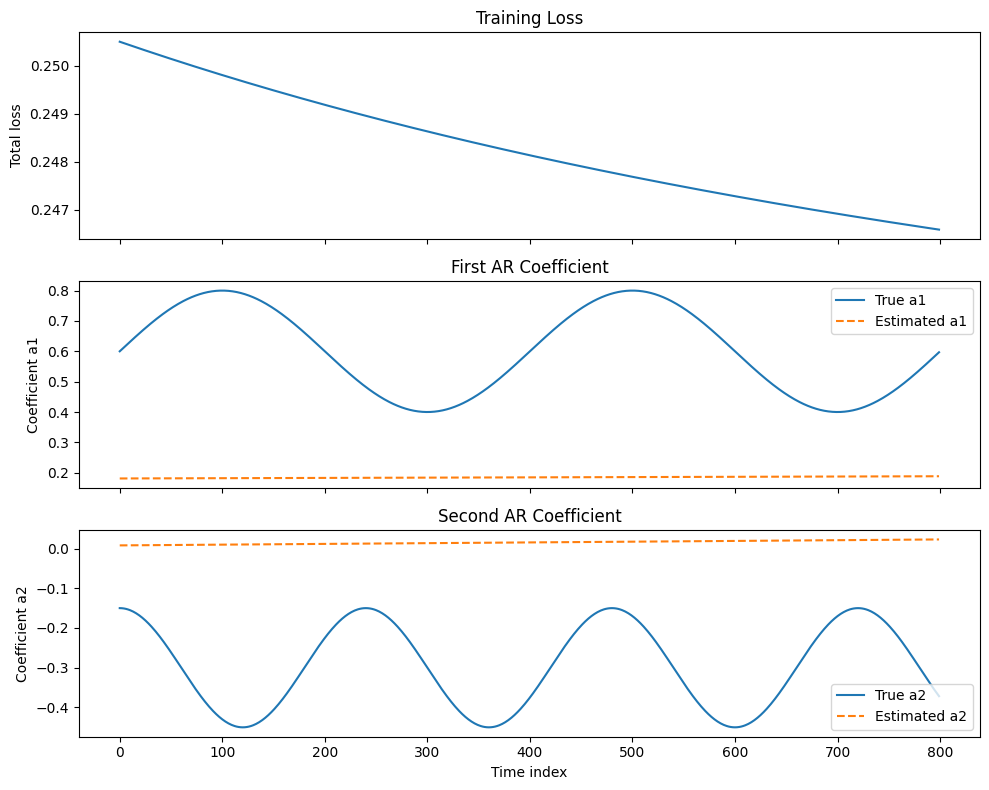

In [6]:

# Neural network architecture parameters
hidden_size = 10
learning_rate = 0.01
epochs = 800

# Initialize neural network weights (two hidden layers)
# Use small random values for stability
w1 = 0.1 * np.random.randn(1, hidden_size)
b1 = np.zeros(hidden_size)
w2 = 0.1 * np.random.randn(hidden_size, hidden_size)
b2 = np.zeros(hidden_size)
w3 = 0.1 * np.random.randn(hidden_size, 2)
b3 = np.zeros(2)

# Activation function (tanh)
def tanh(z):
    return np.tanh(z)

def tanh_deriv(z):
    return 1.0 - np.tanh(z)**2

# Helper to forward-pass through the network
def forward_network(tnorm):
    # Input layer (scalar time normalized)
    z1 = tnorm[:, None] @ w1 + b1
    h1 = tanh(z1)
    z2 = h1 @ w2 + b2
    h2 = tanh(z2)
    z3 = h2 @ w3 + b3
    return z3, (h1, h2, z1, z2)

# Helper to compute sliding-window power
def sliding_power(signal, W):
    N = len(signal)
    P = np.zeros(N)
    for i in range(N):
        start = max(0, i-W+1)
        window = signal[start:i+1]
        P[i] = np.mean(window**2)
    return P

# Training loop
loss_history = []
a1_hat_list = []
a2_hat_list = []

# Pre-compute normalized time input
tnorm = np.linspace(0, 1, N)

for epoch in range(epochs):
    # Forward pass: predict coefficients
    pred, cache = forward_network(tnorm)
    a1_hat = pred[:, 0]
    a2_hat = pred[:, 1]
    
    # Compute autoregressive residuals
    res = np.zeros(N)
    for n in range(2, N):
        res[n] = x[n] - (a1_hat[n] * x[n-1] + a2_hat[n] * x[n-2])
    
    # Compute data fit loss (mean squared of residuals)
    loss_ar = np.mean(res[2:]**2)
    
    # Compute energy penalty
    P_hat = sliding_power(x, W)
    loss_energy = np.mean((P_hat - P0)**2)
    
    # Compute smoothness regularizer (difference between consecutive coeffs)
    smoothness = np.mean(np.diff(a1_hat)**2) + np.mean(np.diff(a2_hat)**2)

    # Total loss with hyperparameters
    lam_ar = 1.0
    lam_energy = 1.0
    lam_smooth = 0.1
    total_loss = lam_ar * loss_ar + lam_energy * loss_energy + lam_smooth * smoothness
    loss_history.append(total_loss)
    
    # Backpropagation: compute gradients manually
    # Gradients w.r.t. network outputs (a1_hat, a2_hat)
    # dLoss/d a_k = dLoss_ar/d a_k + lam_smooth * smoothness gradient
    dL_da1 = np.zeros(N)
    dL_da2 = np.zeros(N)
    
    # Gradient from data fit term
    for n in range(2, N):
        d = -2 * res[n]
        dL_da1[n] += lam_ar * d * x[n-1] / (N-2)
        dL_da2[n] += lam_ar * d * x[n-2] / (N-2)
    
    # Gradient from smoothness term
    da1_diff = np.diff(a1_hat)
    da2_diff = np.diff(a2_hat)
    # For interior points, accumulate derivative contributions
    for n in range(1, N-1):
        dL_da1[n] += lam_smooth * 2 * (2 * a1_hat[n] - a1_hat[n-1] - a1_hat[n+1]) / (N-1)
        dL_da2[n] += lam_smooth * 2 * (2 * a2_hat[n] - a2_hat[n-1] - a2_hat[n+1]) / (N-1)

    # Backpropagate through network layers
    # pred = h2 @ w3 + b3
    dL_dz3 = np.column_stack((dL_da1, dL_da2))
    
    h1, h2, z1, z2 = cache
    
    # Gradients for w3 and b3
    dw3 = h2.T @ dL_dz3
    db3 = np.sum(dL_dz3, axis=0)
    
    # Backprop to hidden layer 2
    dh2 = dL_dz3 @ w3.T
    dz2 = dh2 * tanh_deriv(z2)
    
    # Gradients for w2 and b2
    dw2 = h1.T @ dz2
    db2 = np.sum(dz2, axis=0)
    
    # Backprop to hidden layer 1
    dh1 = dz2 @ w2.T
    dz1 = dh1 * tanh_deriv(z1)
    
    # Gradients for w1 and b1
    dw1 = tnorm[:, None].T @ dz1
    db1 = np.sum(dz1, axis=0)
    
    # Update weights with gradient descent
    w3 -= learning_rate * dw3
    b3 -= learning_rate * db3
    w2 -= learning_rate * dw2
    b2 -= learning_rate * db2
    w1 -= learning_rate * dw1
    b1 -= learning_rate * db1
    
    # Track predicted coefficients for analysis
    if epoch == epochs - 1:
        a1_hat_list = a1_hat.copy()
        a2_hat_list = a2_hat.copy()

# Plot loss curve and compare coefficients
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(loss_history)
axes[0].set_ylabel('Total loss')
axes[0].set_title('Training Loss')

axes[1].plot(a1_true, label='True a1')
axes[1].plot(a1_hat_list, label='Estimated a1', linestyle='--')
axes[1].set_ylabel('Coefficient a1')
axes[1].legend()
axes[1].set_title('First AR Coefficient')

axes[2].plot(a2_true, label='True a2')
axes[2].plot(a2_hat_list, label='Estimated a2', linestyle='--')
axes[2].set_ylabel('Coefficient a2')
axes[2].set_xlabel('Time index')
axes[2].legend()
axes[2].set_title('Second AR Coefficient')

plt.tight_layout()


## Discussion
The learned coefficients in this minimal PINN implementation do not closely track the true time-varying AR coefficients.
Several factors contribute to this issue:
- **Identifiability**: With a constant window-power constraint, multiple coefficient trajectories can produce similar signals,
  making it difficult for the network to distinguish the true coefficients【988150528581547†L918-L933】.
- **Manual gradients and small network**: The network uses manual gradient calculations and a small architecture, which limits its expressive
  power and ability to approximate complex coefficient dynamics.
- **Weight scaling**: Training the network via basic gradient descent can get stuck in flat regions of the loss landscape.

### Enhancements
To improve coefficient estimation, consider the following approaches:
1. **Use Automatic Differentiation Frameworks**: Implement the PINN in PyTorch or TensorFlow to leverage automatic differentiation,
   better optimisation algorithms (e.g., Adam), and deeper architectures.
2. **Parameterise with Stability Constraints**: Enforce that the AR polynomial roots remain outside the unit circle (stability)
   via reparameterisation or penalties to avoid unstable coefficients.
3. **Augment Loss with Additional Physics**: Include envelope or spectral constraints, or cross-correlation penalties that emphasise
   phase relationships. Introduce a direct penalty on the difference between successive coefficients or a stronger smoothness weight.
4. **Bayesian or Sequential Methods**: Incorporate Bayesian filtering or sequential message-passing algorithms specifically designed for TVAR models【672647501557241†L152-L160】.
5. **Data Augmentation**: Train on multiple simulated signals or use an ensemble of models to mitigate overfitting to a single sample.

These enhancements may significantly improve recovery of the time-varying coefficients and yield results that are more consistent with the underlying dynamics.
